In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import preprocessing
import seaborn as sns

In [6]:
# read files
tr_raw = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
result = pd.read_csv('dataset/sample_submission.csv')

In [7]:
# null-check
print("Check Null data in train dataset\n",tr_raw.isnull().sum())
print("*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*")
print("Check Null data in test dataset\n",test.isnull().sum())
print("*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*")
tr_ = tr_raw.copy()

Check Null data in train dataset
 id                     0
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    3
Delta 15 N (o/oo)      3
Delta 13 C (o/oo)      3
Body Mass (g)          0
dtype: int64
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Check Null data in test dataset
 id                     0
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    6
Delta 15 N (o/oo)      9
Delta 13 C (o/oo)      8
dtype: int64
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


In [8]:
# one-hot-encoding
print("Process : One hot encoding")
tr_.replace({'Yes': 1, 'No': 0, 'MALE': 1, "FEMALE": 0}, inplace=True)
test.replace({'Yes': 1, 'No': 0, 'MALE': 1, "FEMALE": 0}, inplace=True)
tr_ = pd.concat([tr_, pd.get_dummies(tr_[['Island','Species']])], axis=1)
test = pd.concat([test, pd.get_dummies(test[['Island','Species']])], axis=1)
tr_.drop(['Island', 'Species'], axis=1, inplace=True)
test.drop(['Island', 'Species'], axis=1, inplace=True)
print("Complete : One hot encoding")
print(tr_.columns)
print(test.columns)


Process : One hot encoding
Complete : One hot encoding
Index(['id', 'Clutch Completion', 'Culmen Length (mm)', 'Culmen Depth (mm)',
       'Flipper Length (mm)', 'Sex', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)',
       'Body Mass (g)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen',
       'Species_Adelie Penguin (Pygoscelis adeliae)',
       'Species_Chinstrap penguin (Pygoscelis antarctica)',
       'Species_Gentoo penguin (Pygoscelis papua)'],
      dtype='object')
Index(['id', 'Clutch Completion', 'Culmen Length (mm)', 'Culmen Depth (mm)',
       'Flipper Length (mm)', 'Sex', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)',
       'Island_Biscoe', 'Island_Dream', 'Island_Torgersen',
       'Species_Adelie Penguin (Pygoscelis adeliae)',
       'Species_Chinstrap penguin (Pygoscelis antarctica)',
       'Species_Gentoo penguin (Pygoscelis papua)'],
      dtype='object')


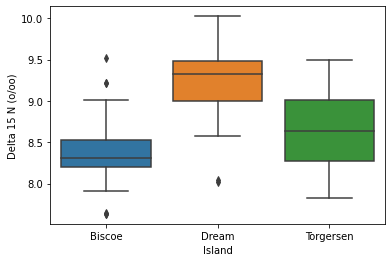

In [9]:
sns.boxplot(x='Island', y='Delta 15 N (o/oo)', data=tr_raw[['Island','Delta 15 N (o/oo)']])
plt.show()

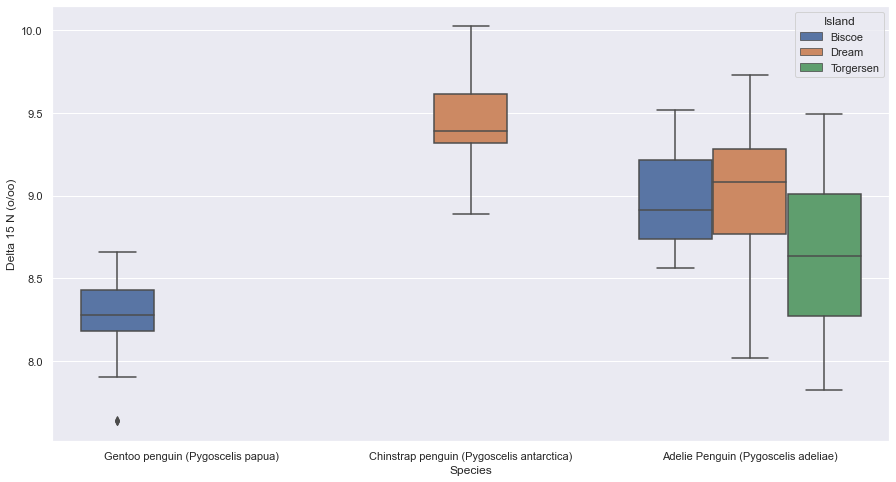

In [11]:
sns.set(rc={'figure.figsize':(15,8)})
sns.boxplot(x='Species',y='Delta 15 N (o/oo)', hue='Island',data=tr_raw[['Island', 'Species', 'Delta 15 N (o/oo)']])
plt.show()

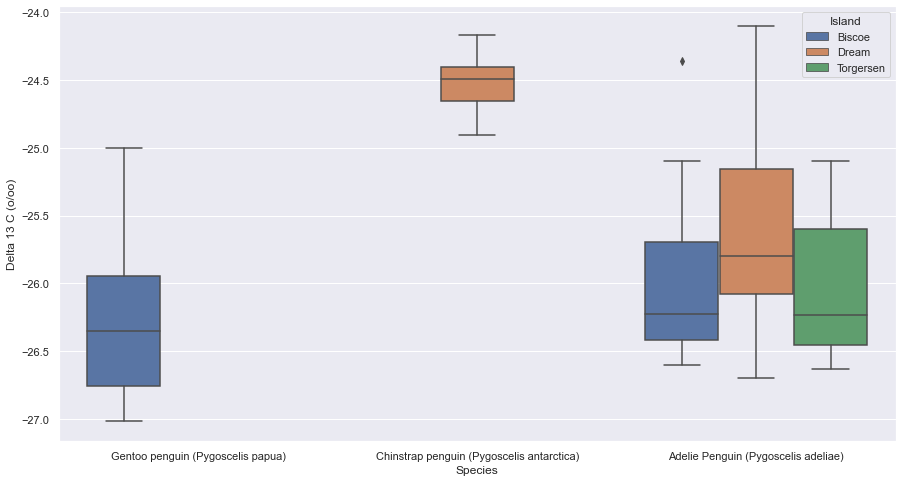

In [13]:
sns.set(rc={'figure.figsize':(15,8)})
sns.boxplot(x='Species',y='Delta 13 C (o/oo)', hue='Island',data=tr_raw[['Island', 'Species', 'Delta 13 C (o/oo)']])
plt.show()

In [16]:
sex_features = ['Culmen Length (mm)', 'Culmen Depth (mm)',
       'Flipper Length (mm)','Species_Adelie Penguin (Pygoscelis adeliae)',
       'Species_Chinstrap penguin (Pygoscelis antarctica)',
       'Species_Gentoo penguin (Pygoscelis papua)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen'
       ]

In [21]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

models = []
models.append(('LR',LogisticRegression(solver='liblinear',multi_class = 'ovr')))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC(gamma='auto')))
models.append(('RFC',RandomForestClassifier()))
models.append(('XGBC',XGBClassifier(iterations=10000,verbose=False, verbosity=0)))
models.append(('LGBMC',LGBMClassifier()))
models.append(('AdaC',AdaBoostClassifier()))
models.append(('Cat',CatBoostClassifier(iterations=10000,verbose=False)))
results =[]
names = []
for name, model in models:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,tr_[sex_features].iloc[tr_['Sex'].dropna().index]
                               ,tr_['Sex'].iloc[tr_['Sex'].dropna().index]
                               ,cv= kfold,scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

LR : 0.721212 (0.083320) 
LDA : 0.874242 (0.091926) 
KNN : 0.775000 (0.092291) 
CART : 0.756061 (0.101062) 
NB : 0.702273 (0.147447) 
SVM : 0.737879 (0.138543) 
RFC : 0.792424 (0.091926) 
XGBC : 0.801515 (0.113879) 
LGBMC : 0.837879 (0.120462) 
AdaC : 0.891667 (0.068270) 
Cat : 0.810606 (0.086044) 


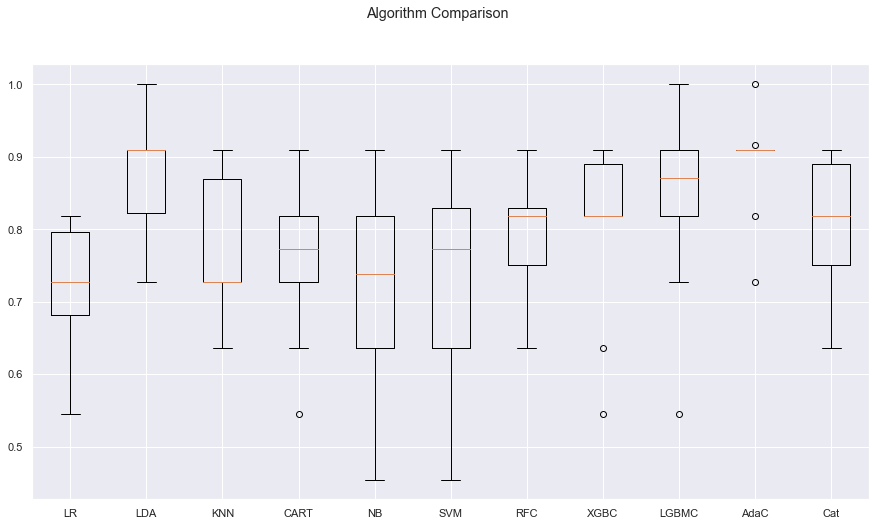

In [22]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [25]:
sex_model = AdaBoostClassifier()
sex_model.fit(tr_[sex_features].iloc[tr_['Sex'].dropna().index],tr_['Sex'].iloc[tr_['Sex'].dropna().index])
tr_['Sex'].iloc[np.where(tr_['Sex'].isnull()==True)] =  sex_model.predict(tr_[tr_['Sex'].isnull()][sex_features])
test['Sex'].iloc[np.where(test['Sex'].isnull()==True)] =  sex_model.predict(test[test['Sex'].isnull()][sex_features])